In [3]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import folium as fl
import wordcloud as wc
from wordcloud import STOPWORDS,WordCloud
%matplotlib inline
import collections

In [5]:
months = ['\\april','\\febrouary','\march']
months2 = ['febrouary','march','april']
files = ['\listings.csv','\listings0.csv']
inputPath= r"C:\Users\myrto\Desktop\data"
# inputPath= r"C:\Users\nikol\Desktop\dataMining_p1\data\data"
columnlist = ['id','zipcode','transit','bedrooms','beds','review_scores_rating','number_of_reviews','neighbourhood','name','latitude','longitude','last_review','instant_bookable','host_since','host_response_rate','host_identity_verified','host_has_profile_pic','first_review','description','city','cancellation_policy','bed_type','bathrooms','accommodates','amenities','room_type','property_type','price','availability_365','minimum_nights','host_id']
# monthDictionary = {'april':('')}

framelist = []
monthlist = []
i=0
for month in months:
    for file in files:
        tempfile = pd.read_csv(inputPath+month+file,index_col=False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df = pd.DataFrame(data = train, columns=columnlist)
    df.insert(loc=len(df.columns),column='month_id',value=months2[i])
    monthlist.append(df)
    i=i+1

df = pd.concat(monthlist)
df.drop_duplicates(ignore_index=True,inplace=True)
df['price'] = df['price'].apply(lambda x: x.translate(str.maketrans({',':'','$':''})))
df['price'] = pd.to_numeric(df['price'])

df.to_csv("train.csv")


# df.fillna(df.mean(),inplace=True)
# df.fillna(method='backfill',inplace=True)
df.dropna(inplace=True)

count_nan = len(df)-df.count()
print(count_nan)


id                        0
zipcode                   0
transit                   0
bedrooms                  0
beds                      0
review_scores_rating      0
number_of_reviews         0
neighbourhood             0
name                      0
latitude                  0
longitude                 0
last_review               0
instant_bookable          0
host_since                0
host_response_rate        0
host_identity_verified    0
host_has_profile_pic      0
first_review              0
description               0
city                      0
cancellation_policy       0
bed_type                  0
bathrooms                 0
accommodates              0
amenities                 0
room_type                 0
property_type             0
price                     0
availability_365          0
minimum_nights            0
host_id                   0
month_id                  0
dtype: int64


In [10]:
# 1
dt = df['room_type'].value_counts().head(1)
tempdf = DataFrame(data=dt)
tempdf 

,room_type
Entire home/apt,25530


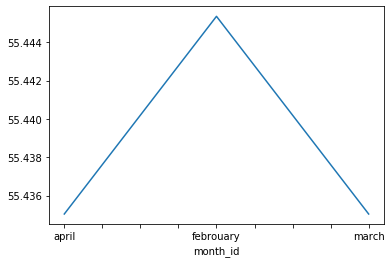

In [6]:
# 2

groupbymonth = df.groupby(by='month_id')
dfaverage = groupbymonth['price'].mean()
dfaverage.plot(x='per_month',y='price')


In [9]:
# groupbymonth = priceDf.groupby(by='month_id')
# dfaverage = groupbymonth['price'].mean()
# dfaverage.plot(x='per_month',y='price')

In [8]:
# 3

temp = df[['id','neighbourhood']]
# reviews = r'C:\Users\myrto\Desktop\data\april\reviews.csv'
# reviews0 = r'C:\Users\myrto\Desktop\data\april\reviews0.csv'
reviews = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews.csv'
reviews0 = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews0.csv'
reviews = pd.read_csv(reviews,columns=['id','comments'])
reviews0 = pd.read_csv(reviews0,columns=['id','comments'])
reviews = pd.DataFrame(data=reviews)
reviews0 = pd.DataFrame(data=reviews0)
reviews = reviews.combine_first(reviews0)
reviews.dropna(inplace=True)
temp = temp.combine_first(reviews)
temp = temp[['neighbourhood','comments']].groupby('neighbourhood',as_index=False).count()
temp = temp.sort_values(['comments'],ascending=False)
temp.head(5).style.hide_index()


neighbourhood,comments
Plaka,3348
Neos Kosmos,2427
Koukaki,2418
Kolonaki,1833
Pangrati,1806


In [9]:
#4
df.groupby(by='neighbourhood',as_index=False).agg({'host_id':'nunique'}).sort_values(['host_id'],ascending=False,ignore_index=True).head(1).style.hide_index()

neighbourhood,host_id
Plaka,574


In [7]:
#5
temp = df.groupby('neighbourhood').nunique()
temp = temp['id']
print(temp)
print('\n')

temp = df.groupby('month_id').nunique()
temp = temp['id']
print(temp)


neighbourhood
Agios Loukas                         19
Agios Nikolaos                       98
Akadimia Platonos                    20
Ambelokipi                          258
Attiki                              136
Exarcheia                           238
Gazi                                 36
Goudi                                12
Ilisia                               90
Kerameikos                          215
Kolonaki                            310
Kolonos                              69
Koukaki                             494
Kypseli                             106
Larissis                            270
Metaxourgeio                        214
Mets                                142
Monastiraki                          17
Neapoli                              98
Neos Kosmos                         450
Pangrati                            303
Patisia                              96
Pedion Areos                         86
Petralona                           130
Plaka                     

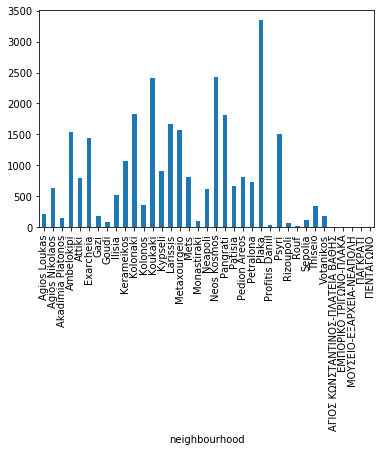

In [10]:
#6
graph = df.groupby(by='neighbourhood').size()
graph.plot.bar(y='Count',x='Neighbourhoods')

In [8]:
#7
temp = df[['room_type','neighbourhood','host_id']]
temp.dropna(inplace=True)
temp.drop_duplicates(subset='host_id',inplace=True)
temp = temp.groupby(['neighbourhood','room_type']).size().sort_values(ascending=False)
temp


neighbourhood    room_type      
Plaka            Entire home/apt    285
Koukaki          Entire home/apt    283
Neos Kosmos      Entire home/apt    249
Kolonaki         Entire home/apt    198
Ambelokipi       Entire home/apt    187
                                   ... 
Profitis Daniil  Shared room          1
Kolonos          Shared room          1
Patisia          Private room         1
Monastiraki      Private room         1
ΠΕΝΤΑΓΩΝΟ        Entire home/apt      1
Length: 63, dtype: int64

In [20]:
# 8
tempdf = df[['room_type','host_id','price']]
# tempdf.dropna(inpl)
tempdf.drop_duplicates(subset='host_id',inplace=True)
tempdf.groupby(by=['room_type'],as_index=False).agg({'price':'mean'}).sort_values(['price'],ascending=False,ignore_index=True).style.hide_index()

room_type,price
Entire home/apt,51.890359
Private room,27.703226
Shared room,25.250000


In [21]:
# 9
latitude = []
longitude = []
tempdf = df[['latitude','longitude','host_id','price','bed_type','room_type']]
tempdf.drop_duplicates(subset='host_id',inplace=True)
latitude = tempdf['latitude'].tolist()
longitude = tempdf['longitude'].tolist()
price = tempdf['price'].tolist()
btype = tempdf['bed_type'].tolist()
rtype = tempdf['room_type'].tolist()

tooltip = 'Click me!'

m = fl.Map(location=[latitude[0],longitude[0]], zoom_start=12,tiles='Stamen Terrain')

for i, j in zip(range(1,100),range(1,100)):
    fl.Marker(location=[latitude[i], longitude[j]], icon=fl.Icon(color='red', icon='info-sign'),tooltip=tooltip,popup=('$'+str(price[i])+'\n'+str(rtype[i])+'\n'+str(btype[i]))).add_to(m)
m



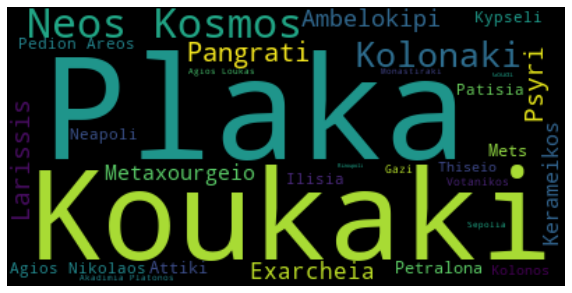

In [19]:
# 10

text = df['neighbourhood']
text = text.tolist()
tuples = collections.Counter(text)

# wordcloud2 = WordCloud().generate(text)
words = WordCloud().generate_from_frequencies(frequencies=dict(tuples))

plt.figure(figsize=(10,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()

